In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import tqdm

In [3]:
import random
import pandas as pd 
import numpy as np
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable


In [4]:
df = pd.read_csv('../data/MNQ DEC23.Last-500-Volume-Action.txt')
df.head()

,date,open,high,low,close,vol,ft,action
0,2023-10-02 22:00:38,14992.00,14992.25,14986.50,14989.50,500,-0.342828,0
1,2023-10-02 22:03:41,14989.75,14992.50,14988.25,14990.50,500,-0.062081,0
2,2023-10-02 22:08:04,14991.00,14992.75,14989.50,14992.00,500,0.396141,0
3,2023-10-02 22:13:26,14992.00,14995.00,14987.75,14989.75,500,0.204056,0
4,2023-10-02 22:14:44,14989.75,14999.00,14989.75,14997.50,500,0.449363,0


In [5]:
# Configure device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]


scaler = MinMaxScaler(feature_range=(-1, 1))
df['scaled'] = scaler.fit_transform(df['close'].values.reshape(-1,1))

look_back = 60 # choose sequence length
X_train, y_train, X_test, y_test = load_data(df[['scaled']], look_back)
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ',y_train.shape)
print('X_test.shape = ',X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (49418, 59, 1)
y_train.shape =  (49418, 1)
X_test.shape =  (12355, 59, 1)
y_test.shape =  (12355, 1)


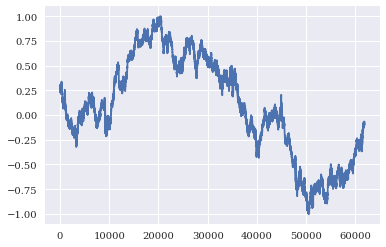

In [7]:
plt.plot(df['scaled'])

In [8]:
X_train[0].reshape((-1)),X_train[1].reshape((-1))

(array([0.2787194 , 0.28022599, 0.28248588, 0.27909605, 0.29077213,
        0.28851224, 0.2960452 , 0.29868173, 0.30621469, 0.29792844,
        0.29152542, 0.28587571, 0.28474576, 0.28700565, 0.28022599,
        0.27683616, 0.28549906, 0.28286252, 0.28022599, 0.27532957,
        0.27570621, 0.26704331, 0.26779661, 0.26516008, 0.26591337,
        0.27382298, 0.28135593, 0.28097928, 0.28625235, 0.2960452 ,
        0.29190207, 0.28964218, 0.28361582, 0.27758945, 0.27193974,
        0.27457627, 0.26854991, 0.26252354, 0.26177024, 0.25649718,
        0.24896422, 0.24934087, 0.24218456, 0.23879473, 0.23427495,
        0.22900188, 0.23502825, 0.23992467, 0.23427495, 0.23088512,
        0.23728814, 0.24369115, 0.23879473, 0.23841808, 0.24519774,
        0.24557439, 0.24557439, 0.24934087, 0.25423729]),
 array([0.28022599, 0.28248588, 0.27909605, 0.29077213, 0.28851224,
        0.2960452 , 0.29868173, 0.30621469, 0.29792844, 0.29152542,
        0.28587571, 0.28474576, 0.28700565, 0.28022599, 0.

In [9]:
u=3
y_train[u]==X_train[u+1][-1]

array([ True])

In [10]:
# make training and test sets in torch
X_train = torch.from_numpy(X_train).type(torch.Tensor).to(device)
X_test = torch.from_numpy(X_test).type(torch.Tensor).to(device)
y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)

In [20]:
X_train.size(),X_test.size(),y_train.size(),y_test.size()


(torch.Size([49418, 59, 1]),
 torch.Size([12355, 59, 1]),
 torch.Size([49418, 1]),
 torch.Size([12355, 1]))

In [12]:
# Build model
#####################
input_dim = 1
hidden_dim = 40
num_layers = 3 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

model = LSTM(input_dim=input_dim, 
             hidden_dim=hidden_dim,
             output_dim=output_dim,
             num_layers=num_layers).to(device)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 40, num_layers=3, batch_first=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
)
14
torch.Size([160, 1])
torch.Size([160, 40])
torch.Size([160])
torch.Size([160])
torch.Size([160, 40])
torch.Size([160, 40])
torch.Size([160])
torch.Size([160])
torch.Size([160, 40])
torch.Size([160, 40])
torch.Size([160])
torch.Size([160])
torch.Size([1, 40])
torch.Size([1])


38700

In [13]:
y_train.shape,y_train_pred.shape

NameError: name 'y_train_pred' is not defined

In [16]:
X_train.shape

torch.Size([49418, 59, 1])

In [17]:
X_train[0].reshape(-1)

tensor([0.2787, 0.2802, 0.2825, 0.2791, 0.2908, 0.2885, 0.2960, 0.2987, 0.3062,
        0.2979, 0.2915, 0.2859, 0.2847, 0.2870, 0.2802, 0.2768, 0.2855, 0.2829,
        0.2802, 0.2753, 0.2757, 0.2670, 0.2678, 0.2652, 0.2659, 0.2738, 0.2814,
        0.2810, 0.2863, 0.2960, 0.2919, 0.2896, 0.2836, 0.2776, 0.2719, 0.2746,
        0.2685, 0.2625, 0.2618, 0.2565, 0.2490, 0.2493, 0.2422, 0.2388, 0.2343,
        0.2290, 0.2350, 0.2399, 0.2343, 0.2309, 0.2373, 0.2437, 0.2388, 0.2384,
        0.2452, 0.2456, 0.2456, 0.2493, 0.2542], device='cuda:0')

In [19]:
y_train.shape

torch.Size([49418, 1])

In [15]:
# Train model
#####################
num_epochs = 100
hist = []
# hist = np.zeros((int(len(train_data)/128)+1)*num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  
batch_size=128
t = 0
for t in tqdm.tqdm_notebook(range(num_epochs)):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    train_data = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    for batch_X, batch_y in train_loader:
        t+=1
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        # Forward pass
        y_train_pred = model(batch_X)

        loss = loss_fn(y_train_pred, batch_y)
        if t % 100 == 0 and t !=0:
            print("Epoch ", t, "MSE: ", loss.item())
        hist.append(loss.item())

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()

Epoch  100 MSE:  0.00017756933812052011
Epoch  200 MSE:  8.597180567448959e-05
Epoch  300 MSE:  0.0002290162956342101
Epoch  100 MSE:  6.154070433694869e-05
Epoch  200 MSE:  0.00017475549248047173
Epoch  300 MSE:  0.0002457574591971934
Epoch  100 MSE:  0.00016305292956531048
Epoch  200 MSE:  5.039728421252221e-05
Epoch  300 MSE:  4.510112921707332e-05
Epoch  100 MSE:  5.72124554309994e-05
Epoch  200 MSE:  6.802204006817192e-05



KeyboardInterrupt: 

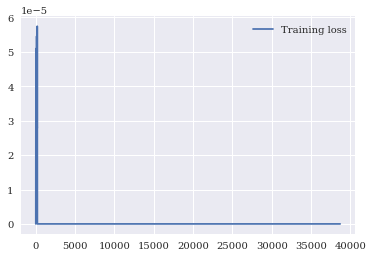

In [27]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [56]:
# make predictions
y_test_pred = model(X_test)

In [57]:
y_test_pred

tensor([[-0.7764],
        [-0.7744],
        [-0.7805],
        ...,
        [-0.0716],
        [-0.0748],
        [-0.0725]], device='cuda:0', grad_fn=<AddmmBackward>)

In [65]:
y_train_pred = model(X_train)

In [66]:
y_train_pred

tensor([[ 0.2518],
        [ 0.2582],
        [ 0.2667],
        ...,
        [-0.7837],
        [-0.7809],
        [-0.7765]], device='cuda:0', grad_fn=<AddmmBackward>)

In [67]:
# invert predictions
y_train_pred_inv = scaler.inverse_transform(y_train_pred.to('cpu').detach().numpy())
y_train_inv = scaler.inverse_transform(y_train.to('cpu').detach().numpy())
y_test_pred_inv = scaler.inverse_transform(y_test_pred.to('cpu').detach().numpy())
y_test_inv = scaler.inverse_transform(y_test.to('cpu').detach().numpy())

In [68]:
y_train_pred_inv.shape, y_train_inv.shape, y_test_pred_inv.shape, y_test_inv.shape, 

((49418, 1), (49418, 1), (12355, 1), (12355, 1))

In [90]:
y_train_pred.reshape(-1).cpu().detach().numpy()[:100]

array([0.25177783, 0.25815067, 0.266679  , 0.26853108, 0.27235532,
       0.26879084, 0.2705104 , 0.27024108, 0.27034926, 0.26915967,
       0.2764141 , 0.28328484, 0.2693699 , 0.2739815 , 0.2788936 ,
       0.27620882, 0.27902073, 0.2668152 , 0.2599809 , 0.25324103,
       0.25383657, 0.2548558 , 0.26506895, 0.26981717, 0.27094376,
       0.27726144, 0.27764934, 0.27314144, 0.2674033 , 0.25126344,
       0.25714457, 0.26357198, 0.26026887, 0.26212868, 0.27196613,
       0.2755269 , 0.27982873, 0.28314835, 0.28549492, 0.27315572,
       0.27634352, 0.26720488, 0.27684912, 0.2655174 , 0.26613137,
       0.26287413, 0.2653634 , 0.2578137 , 0.26254863, 0.2529039 ,
       0.25955802, 0.26062945, 0.26714575, 0.2693267 , 0.25782326,
       0.27066687, 0.26768768, 0.26953983, 0.27473003, 0.26929915,
       0.26557618, 0.26481515, 0.2620187 , 0.2667253 , 0.26541635,
       0.26863438, 0.2704493 , 0.26200527, 0.25990152, 0.2547486 ,
       0.26036647, 0.26521325, 0.26734123, 0.27185607, 0.27312

In [69]:
model.eval()

LSTM(
  (lstm): LSTM(1, 40, num_layers=3, batch_first=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
)

In [71]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_inv[:,0], y_train_pred_inv[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_inv[:,0], y_test_pred_inv[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.84 RMSE
Test Score: 5.39 RMSE


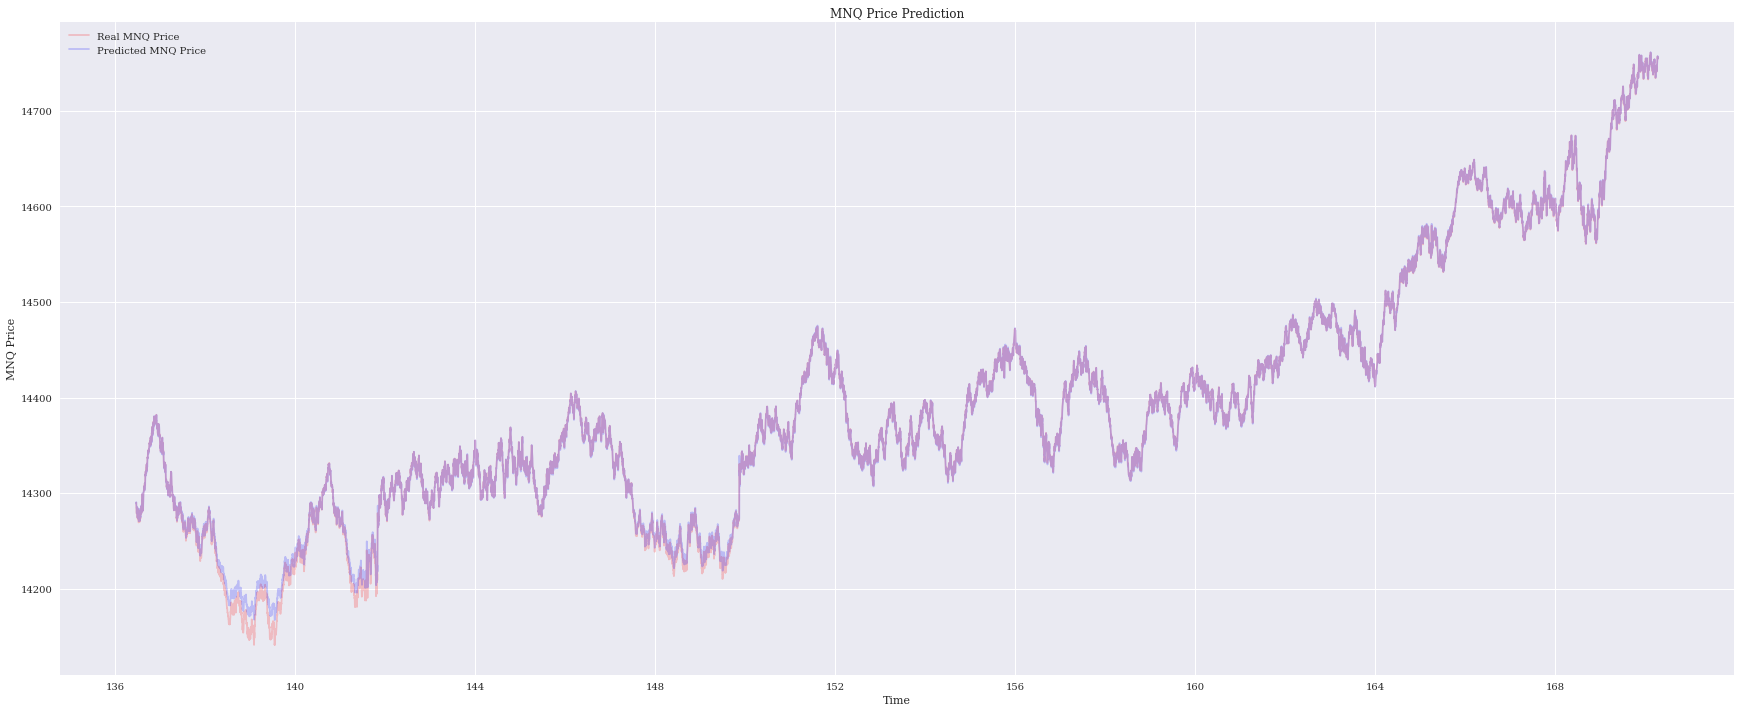

In [77]:
# Visualising the results
figure, axes = plt.subplots(figsize=(30, 12))
axes.xaxis_date()

axes.plot(df[len(df)-len(y_test_inv):].index, y_test_inv, color = 'red', label = 'Real MNQ Price', alpha=0.2)
axes.plot(df[len(df)-len(y_test_inv):].index, y_test_pred_inv, color = 'blue', label = 'Predicted MNQ Price', alpha=0.2)
#axes.xticks(np.arange(0,394,50))
plt.title('MNQ Price Prediction')
plt.xlabel('Time')
plt.ylabel('MNQ Price')
plt.legend()
# plt.savefig('ibm_pred.png')
plt.show()

-0.7877833 y=-0.7751412391662598
-0.7891322 y=-0.7811676263809204
-0.79166853 y=-0.7838041186332703
-0.79460526 y=-0.7860640287399292
-0.797628 y=-0.7924670577049255
-0.80064774 y=-0.7822975516319275
-0.8036445 y=-0.7856873869895935
-0.8066135 y=-0.7890772223472595
-0.8095525 y=-0.7879472970962524
-0.812459 y=-0.7917137742042542
-0.8153313 y=-0.7996233701705933
-0.8181676 y=-0.7954802513122559
-0.82096756 y=-0.7883239388465881
-0.8237301 y=-0.7864406704902649
-0.8264549 y=-0.7849341034889221
-0.8291415 y=-0.7860640287399292
-0.8317898 y=-0.7905837893486023
-0.83439934 y=-0.7935969829559326
-0.83697027 y=-0.8022598624229431
-0.8395023 y=-0.7981167435646057
-0.8419955 y=-0.8064030408859253
-0.8444497 y=-0.803389847278595
-0.84686494 y=-0.7973634600639343
-0.8492413 y=-0.7962335348129272
-0.85157865 y=-0.7890772223472595
-0.8538773 y=-0.7871939539909363
-0.85613704 y=-0.7924670577049255
-0.8583584 y=-0.7969868183135986
-0.86054116 y=-0.801129937171936
-0.86268556 y=-0.804519772529602


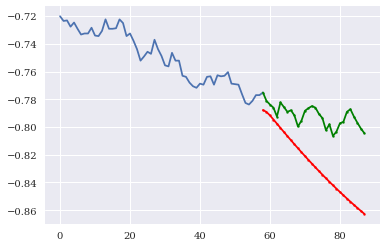

In [58]:
pred_shift = 0
pred_size = 30
__len = X_test.shape[1]

predictions = []
new_data = X_test[[pred_shift]]


for i in range(pred_size):
    data_pred = model(new_data.to(device)).cpu()
    predictions.append(data_pred.detach().numpy()[0][0])
    new_data = np.concatenate([new_data.cpu().reshape(-1),data_pred.cpu().detach().numpy()[0]])
    print(predictions[-1],f'y={y_test[pred_shift+i].cpu().detach().numpy()[0]}')
    new_data = new_data[1:].reshape(1,__len,1)
    new_data = torch.tensor(new_data, dtype=torch.float32)
# plt.plot(X_test[pred_shift])
__x = 0
plt.plot(X_test[pred_shift+1].cpu().detach().numpy())
plt.plot(range(__len-1,pred_size+__len-1), X_test[pred_shift+pred_size].cpu().detach().numpy()[-pred_size:], color='green')
plt.scatter(range(__len-1,pred_size+__len-1), X_test[pred_shift+pred_size].cpu().detach().numpy()[-pred_size:], color='green', s=4)
plt.plot(range(__len-1,pred_size+__len-1), predictions, color='red')
plt.scatter(range(__len-1,pred_size+__len-1), predictions, color='red', s=4)
plt.show()

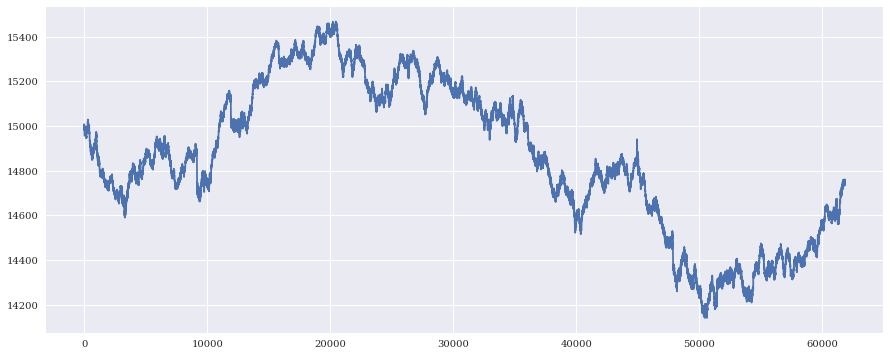

In [75]:
plt.figure(figsize=(15, 6))
plt.plot(df['close'])
df[len(df)-len(y_test_inv):].index, y_test_pred
plt.show()